In [1]:
# 导入包
import torch
import torch.nn as nn
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
# 启动matplotlib交互模式

In [2]:
%matplotlib inline

In [3]:
"""

基于pytorch框架编写模型训练
实现一个自行构造的找规律(机器学习)任务
规律：x是一个5维向量，最大的数字在哪维就属于哪一类。

"""

'\n\n基于pytorch框架编写模型训练\n实现一个自行构造的找规律(机器学习)任务\n规律：x是一个5维向量，最大的数字在哪维就属于哪一类。\n\n'

In [4]:
# 可以设置随机种子seed，保证每次的随机数都是一样的
def setup_seed(seed):
    torch.manual_seed(seed)

# 设置随机数种子
setup_seed(42)

In [5]:
# 生成一个样本, 样本的生成方法，代表了我们要学习的规律
# 随机生成一个5维向量，最大的数字在哪维就属于哪一类。
def build_sample():
    x = np.random.random(5)
    y = np.zeros(5)
    y[np.argmax(x)] = 1
    return x, y

# 随机生成一批样本，这里存储一下
def build_dataset(total_sample_num):
    X = np.empty((total_sample_num, 5))
    Y = np.empty((total_sample_num, 5))
    for i in range(total_sample_num):
        X[i], Y[i] = build_sample()
    X = torch.FloatTensor(X)
    Y = torch.FloatTensor(Y)
    # 保存为 PyTorch 文件（单个文件包含两个张量）
    torch.save({'X': X, 'Y': Y}, 'dataset.pt')
    return torch.FloatTensor(X), torch.FloatTensor(Y)

# build_dataset(10000)

In [6]:
# 定义模型
class TorchModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TorchModel, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)  # 线性层
        self.linear2 = nn.Linear(hidden_size, 5)
        self.sig = nn.Sigmoid()  # nn.Sigmoid() sigmoid归一化函数
        self.relu = nn.ReLU()
        self.loss = nn.CrossEntropyLoss()  # loss函数采用交叉熵损失

    # 当输入真实标签，返回loss值；无真实标签，返回预测值
    def forward(self, x, y=None):
        x = self.linear1(x)  # (batch_size, input_size) -> (batch_size, 1)
        x = self.sig(x)  # (batch_size, 1) -> (batch_size, 1)
        x = torch.softmax(x, dim=1)
        x = self.linear2(x)
        y_pred = x
        if y is not None:
            return self.loss(y_pred, y)  # 预测值和真实值计算损失
        else:
            return torch.softmax(y_pred, dim=1)  # 输出预测结果

In [7]:
# 验证代码
# 用来测试每轮模型的准确率
def evaluate(model, val_x, val_y):
    model.eval()
    x, y = val_x, val_y
    correct, wrong = 0, 0
    with torch.no_grad():
        y_pred = model(x)  # 模型预测 model.forward(x)
        val_loss = model(x, y).item()
        for y_p, y_t in zip(y_pred, y):  # 与真实标签进行对比
            # print(type(np.argmax(y_p)))  # <class 'torch.Tensor'> 隐式转换
            if y_t[torch.argmax(y_p)] == 1:
                correct += 1  # 分类正确
            else:
                wrong += 1  #分类错误
    print(f"正确预测个数：{correct}, 正确率：{correct / (correct + wrong)}, loss: {val_loss}")
    return correct / (correct + wrong), val_loss

In [ ]:
# 训练代码
def main():
    # 配置参数
    epoch_num = 4000  # 训练轮数
    batch_size = 20  # 每次训练样本个数
    all_sample = 10000  # 每轮训练总共训练的样本总数
    train_sample = 7000
    input_size = 5  # 输入向量维度
    hidden_size = 5
    learning_rate = 0.001  # 学习率
    # 建立模型
    model = TorchModel(input_size, hidden_size)
    log = []
    # 选择优化器
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # 创建训练集，正常任务是读取训练集
    # build_dataset(all_sample)
    loaded_data = torch.load('dataset.pt', weights_only=True)
    X, Y = loaded_data['X'], loaded_data['Y']

    # 分割数据集 7:2:1
    train_x = X[:7000]
    train_y = Y[:7000]
    val_x = X[7000:9000]
    val_y = Y[7000:9000]
    test_x = X[9000:]
    test_y = Y[9000:]
    for i in range(5):
        print(f"本次预测集中共有{int(val_y.sum(dim=0)[i])}个第{i+1}类样本")

    # 训练过程
    for epoch in range(epoch_num):
        model.train()
        watch_loss = np.empty(train_sample // batch_size)
        for batch_index in range(train_sample // batch_size):    
            x = train_x[batch_index * batch_size : (batch_index + 1) * batch_size]
            y = train_y[batch_index * batch_size : (batch_index + 1) * batch_size]
            loss = model(x, y)  # 计算loss  model.forward(x,y)
            loss.backward()  # 计算梯度
            optim.step()  # 更新权重
            optim.zero_grad()  # 梯度归零
            watch_loss[batch_index] = loss.item()
        print("=========\n第%d轮平均loss:%f" % (epoch + 1, np.mean(watch_loss)))
        acc, val_loss = evaluate(model, val_x, val_y)  # 测试本轮模型结果
        log.append([acc, float(np.mean(watch_loss)), val_loss])
    # 保存模型
    torch.save(model.state_dict(), "model.bin")
    # 画图
    print(log)
    return log
log = main()

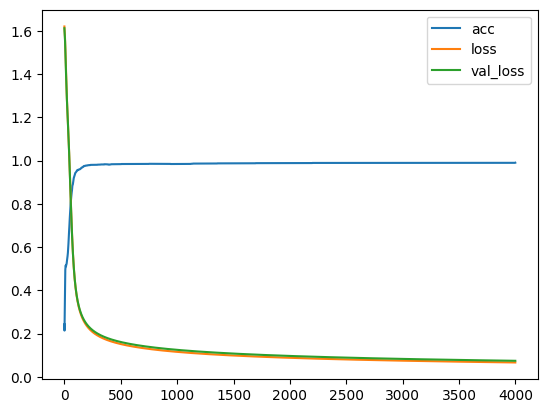

In [9]:
# 绘制训练集loss；验证集acc，loss曲线
plt.plot(range(len(log)), [l[0] for l in log], label="acc")  # 画acc曲线
plt.plot(range(len(log)), [l[1] for l in log], label="loss")  # 画loss曲线
plt.plot(range(len(log)), [l[2] for l in log], label="val_loss")  # 画val_loss曲线
plt.legend()
plt.show()

In [19]:
# 预测代码
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# 在测试集上的预测
def predict_batch(model_path, data_path):
    input_size = 5
    hidden_size = 5
    model = TorchModel(input_size, hidden_size)
    model.load_state_dict(torch.load(model_path, weights_only=True))  # 加载训练好的权重
    print(model.state_dict())
    all_preds = []
    all_targets = []
    
    model.eval()
    loaded_data = torch.load('dataset.pt', weights_only=True)
    x, y = loaded_data['X'][9000:], loaded_data['Y'][9000:]
    correct, wrong = 0, 0
    
    with torch.no_grad():
        y_pred = model(x)  # 模型预测 model.forward(x)
        for y_p, y_t in zip(y_pred, y):  # 与真实标签进行对比
            if y_t[torch.argmax(y_p)] == 1:
                correct += 1  # 分类正确
            else:
                wrong += 1  #分类错误
            all_preds = torch.argmax(y_pred, dim=1).cpu().numpy()
            all_targets = torch.argmax(y, dim=1).cpu().numpy()
    print(f"正确预测个数：{correct}, 正确率：{correct / (correct + wrong)}")
    return correct / (correct + wrong), all_preds, all_targets

# 给定向量或矩阵的预测
def predict_demo(model_path, input_vec):
    input_size = 5
    hidden_size = 5
    model = TorchModel(input_size, hidden_size)
    model.load_state_dict(torch.load(model_path, weights_only=True))  # 加载训练好的权重
    print(model.state_dict())

    model.eval()  # 测试模式
    with torch.no_grad():  # 不计算梯度
        result = model.forward(torch.FloatTensor(input_vec))  # 模型预测
        # result = torch.softmax(result, dim=1)
    for vec, res in zip(input_vec, result):
        print(f"输入：{vec}, 预测类别：{int(torch.argmax(res))}, 概率值：{float(res[torch.argmax(res)])}")  # 打印结果

# 随机创建数据并预测
def predict_rand(model_path, total_sample_num):
    input_size = 5
    hidden_size = 5
    model = TorchModel(input_size, hidden_size)
    model.load_state_dict(torch.load(model_path, weights_only=True))  # 加载训练好的权重
    print(model.state_dict())
    
    model.eval()
    correct, wrong = 0, 0
    X = np.empty((total_sample_num, 5))
    Y = np.empty((total_sample_num, 5))
    for i in range(total_sample_num):
        X[i], Y[i] = build_sample()
    x = torch.FloatTensor(X)
    y = torch.FloatTensor(Y)
    with torch.no_grad():
        y_pred = model(x)  # 模型预测 model.forward(x)
        for y_p, y_t in zip(y_pred, y):  # 与真实标签进行对比
            # print(type(np.argmax(y_p)))  # <class 'torch.Tensor'> 隐式转换
            if y_t[torch.argmax(y_p)] == 1:
                correct += 1  # 分类正确
            else:
                wrong += 1  #分类错误
    print(f"正确预测个数：{correct}, 正确率：{correct / (correct + wrong)}")
    return correct / (correct + wrong)

In [14]:
# 给定向量或矩阵的预测
model_path = "model99.bin"
data_path = "dataset.pt"
input_vec = [[0.07889086,0.15229675,0.31082123,0.03504317,0.88920843],
             [0.74963533,0.5524256,0.95520434,0.95758807,0.84890681],
             [0.00797868,0.67482528,0.13625847,0.34675372,0.19871392],
             [0.09349776,0.59416669,0.92579291,0.41567412,0.1358894],
             [0.92579291,0.59416669,0.09349776,0.41567412,0.1358894]]
predict_demo(model_path, input_vec)

OrderedDict({'linear1.weight': tensor([[-2.8527, 11.4112, -2.6973, -2.6452, -2.9145],
        [11.5419, -2.9421, -2.7019, -2.7162, -2.8453],
        [-2.9655, -3.1308, -2.7830, -2.7689, 11.9883],
        [-2.9963, -2.9210, 11.7614, -2.6883, -2.8955],
        [-2.8464, -2.9848, -2.7229, 11.7184, -2.8416]]), 'linear1.bias': tensor([-3.1685, -3.3012, -3.3245, -3.2065, -3.2036]), 'linear2.weight': tensor([[-32.6237,  86.4699, -29.3211, -30.8301, -29.7906],
        [ 87.8592, -32.6890, -29.0172, -32.7499, -32.2360],
        [-32.8786, -30.8483, -32.7517,  88.7323, -30.8876],
        [-31.4989, -31.4831, -31.6553, -33.4808,  89.3124],
        [-29.4354, -31.0992,  84.9678, -33.5424, -30.5890]]), 'linear2.bias': tensor([-0.0279, -0.0040,  0.0488,  0.1638,  0.5395])})
输入：[0.07889086, 0.15229675, 0.31082123, 0.03504317, 0.88920843], 预测类别：4, 概率值：1.0
输入：[0.74963533, 0.5524256, 0.95520434, 0.95758807, 0.84890681], 预测类别：3, 概率值：0.6187652945518494
输入：[0.00797868, 0.67482528, 0.13625847, 0.34675372, 0

In [31]:
# 随机创建数据并预测
model_path = "model.bin"
predict_rand(model_path, 10000)

OrderedDict({'linear1.weight': tensor([[-2.8799, 11.5018, -2.7153, -2.6807, -2.9423],
        [-2.8843, -3.0355, -2.7452, 11.8481, -2.8744],
        [11.6562, -2.9788, -2.7228, -2.7518, -2.8668],
        [-3.0062, -3.1818, -2.8118, -2.8170, 12.1446],
        [-3.0318, -2.9617, 11.8937, -2.7276, -2.9252]]), 'linear1.bias': tensor([-3.1628, -3.2110, -3.3118, -3.3399, -3.2123]), 'linear2.weight': tensor([[-30.1667, -27.6593,  79.2969, -27.2143, -28.3352],
        [ 80.0335, -29.9528, -29.5694, -27.0126, -30.2569],
        [-30.1449, -28.3212, -27.7083, -30.1760,  81.0823],
        [-29.2941,  80.9646, -28.6814, -29.5954, -31.1997],
        [-26.5997, -27.6786, -27.4304,  77.5233, -30.3481]]), 'linear2.bias': tensor([-0.0384,  0.0070, -0.1882,  0.3821, -0.0645])})
正确预测个数：9910, 正确率：0.991


0.991

In [34]:
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    参数说明：
    cm : 计算好的混淆矩阵
    classes : 类别名称列表
    normalize : 是否归一化显示
    title : 图表标题
    cmap : 颜色映射
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("归一化混淆矩阵")
    else:
        print('未归一化混淆矩阵')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Pred Label', fontsize=12)
    plt.tight_layout()
    plt.show()

OrderedDict({'linear1.weight': tensor([[-2.8799, 11.5018, -2.7153, -2.6807, -2.9423],
        [-2.8843, -3.0355, -2.7452, 11.8481, -2.8744],
        [11.6562, -2.9788, -2.7228, -2.7518, -2.8668],
        [-3.0062, -3.1818, -2.8118, -2.8170, 12.1446],
        [-3.0318, -2.9617, 11.8937, -2.7276, -2.9252]]), 'linear1.bias': tensor([-3.1628, -3.2110, -3.3118, -3.3399, -3.2123]), 'linear2.weight': tensor([[-30.1667, -27.6593,  79.2969, -27.2143, -28.3352],
        [ 80.0335, -29.9528, -29.5694, -27.0126, -30.2569],
        [-30.1449, -28.3212, -27.7083, -30.1760,  81.0823],
        [-29.2941,  80.9646, -28.6814, -29.5954, -31.1997],
        [-26.5997, -27.6786, -27.4304,  77.5233, -30.3481]]), 'linear2.bias': tensor([-0.0384,  0.0070, -0.1882,  0.3821, -0.0645])})
正确预测个数：990, 正确率：0.99
归一化混淆矩阵


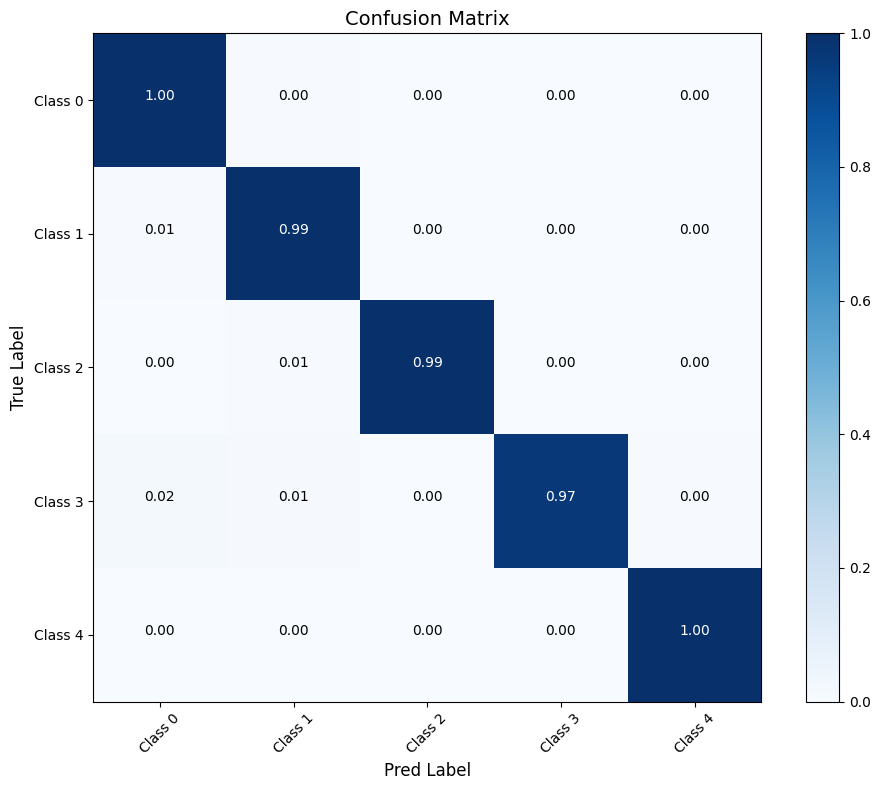

In [35]:
# 在测试集上的预测并绘制混淆矩阵
correct, all_targets, all_preds = predict_batch(model_path, data_path)
# 计算混淆矩阵
cm = confusion_matrix(all_targets, all_preds)

# 可视化
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
plot_confusion_matrix(cm, classes=class_names, normalize=True)